In [2]:
import torch
import numpy as np 
import os
import sys
import numba as nb
import matplotlib.pyplot as plt
import time
from sklearn.datasets import make_swiss_roll, make_moons, make_circles
import ot

os.chdir('/home/baly/projects/linear_opt')

#from lib.library import *
from lib.lib_ot import *
from lib.lib_lopt import *
from lib.geodesic import *

ModuleNotFoundError: No module named 'lib.lib_ot'

In [ ]:
def ot_barycenter(measures_locations, measures_weights, X_init, b=None, weights=None, numItermax=10000,
                            stopThr=1e-7, numThreads=1):
    r"""
    Solves the free support (locations of the barycenters are optimized, not the weights) Wasserstein barycenter problem (i.e. the weighted Frechet mean for the 2-Wasserstein distance), formally:

    .. math::
        \min_\mathbf{X} \quad \sum_{i=1}^N w_i W_2^2(\mathbf{b}, \mathbf{X}, \mathbf{a}_i, \mathbf{X}_i)

    where :

    - :math:`w \in \mathbb{(0, 1)}^{N}`'s are the barycenter weights and sum to one
    - the :math:`\mathbf{a}_i \in \mathbb{R}^{k_i}` are the empirical measures weights and sum to one for each :math:`i`
    - the :math:`\mathbf{X}_i \in \mathbb{R}^{k_i, d}` are the empirical measures atoms locations
    - :math:`\mathbf{b} \in \mathbb{R}^{k}` is the desired weights vector of the barycenter

    This problem is considered in :ref:`[1] <references-free-support-barycenter>` (Algorithm 2).
    There are two differences with the following codes:

    - we do not optimize over the weights
    - we do not do line search for the locations updates, we use i.e. :math:`\theta = 1` in
      :ref:`[1] <references-free-support-barycenter>` (Algorithm 2). This can be seen as a discrete
      implementation of the fixed-point algorithm of
      :ref:`[2] <references-free-support-barycenter>` proposed in the continuous setting.

    Parameters
    ----------
    measures_locations : list of N (k_i,d) array-like
        The discrete support of a measure supported on :math:`k_i` locations of a `d`-dimensional space
        (:math:`k_i` can be different for each element of the list)
    measures_weights : list of N (k_i,) array-like
        Numpy arrays where each numpy array has :math:`k_i` non-negatives values summing to one
        representing the weights of each discrete input measure

    X_init : (k,d) array-like
        Initialization of the support locations (on `k` atoms) of the barycenter
    b : (k,) array-like
        Initialization of the weights of the barycenter (non-negatives, sum to 1)
    weights : (N,) array-like
        Initialization of the coefficients of the barycenter (non-negatives, sum to 1)

    numItermax : int, optional
        Max number of iterations
    stopThr : float, optional
        Stop threshold on error (>0)
    verbose : bool, optional
        Print information along iterations
    log : bool, optional
        record log if True
    numThreads: int or "max", optional (default=1, i.e. OpenMP is not used)
        If compiled with OpenMP, chooses the number of threads to parallelize.
        "max" selects the highest number possible.


    Returns
    -------
    X : (k,d) array-like
        Support locations (on k atoms) of the barycenter


    .. _references-free-support-barycenter:
    References
    ----------
    .. [1] Cuturi, Marco, and Arnaud Doucet. "Fast computation of Wasserstein barycenters." International Conference on Machine Learning. 2014.

    .. [2]  Álvarez-Esteban, Pedro C., et al. "A fixed-point approach to barycenters in Wasserstein space." Journal of Mathematical Analysis and Applications 441.2 (2016): 744-762.

    """

    #nx = get_backend(*measures_locations,*measures_weights,X_init)

    iter_count = 0

    N = len(measures_locations)
    k = X_init.shape[0]
    d = X_init.shape[1]
    # if b is None:
    #     b = nx.ones((k,),type_as=X_init) / k
    # if weights is None:
    #     weights = nx.ones((N,),type_as=X_init) / N

    X = X_init

    # log_dict = {}
    displacement_square_norms = []

    displacement_square_norm = stopThr + 1.

    while (displacement_square_norm > stopThr and iter_count < numItermax):
        T_sum = np.zeros((k, d))
        for (measure_locations_i, measure_weights_i, weight_i) in zip(measures_locations, measures_weights,  weights):
            M_i = cost_matrix_d(X, measure_locations_i)
            T_i = ot.emd(b, measure_weights_i, M_i, numThreads=numThreads)
            T_sum = T_sum + weight_i * 1. / b[:,None] * np.dot(T_i, measure_locations_i)
        displacement_square_norm = np.sum((T_sum - X)**2)
        X = T_sum
        iter_count += 1


    return X


In [98]:
def opt_barycenter(measures_locations, measures_weights, X_init, b, weights,Lambda, numItermax=10000,
                            stopThr=1e-7, numThreads=1):
    r"""
    Solves the free support (locations of the barycenters are optimized, not the weights) Wasserstein barycenter problem (i.e. the weighted Frechet mean for the 2-Wasserstein distance), formally:

    .. math::
        \min_\mathbf{X} \quad \sum_{i=1}^N w_i W_2^2(\mathbf{b}, \mathbf{X}, \mathbf{a}_i, \mathbf{X}_i)

    where :

    - :math:`w \in \mathbb{(0, 1)}^{N}`'s are the barycenter weights and sum to one
    - the :math:`\mathbf{a}_i \in \mathbb{R}^{k_i}` are the empirical measures weights and sum to one for each :math:`i`
    - the :math:`\mathbf{X}_i \in \mathbb{R}^{k_i, d}` are the empirical measures atoms locations
    - :math:`\mathbf{b} \in \mathbb{R}^{k}` is the desired weights vector of the barycenter

    This problem is considered in :ref:`[1] <references-free-support-barycenter>` (Algorithm 2).
    There are two differences with the following codes:

    - we do not optimize over the weights
    - we do not do line search for the locations updates, we use i.e. :math:`\theta = 1` in
      :ref:`[1] <references-free-support-barycenter>` (Algorithm 2). This can be seen as a discrete
      implementation of the fixed-point algorithm of
      :ref:`[2] <references-free-support-barycenter>` proposed in the continuous setting.

    Parameters
    ----------
    measures_locations : list of N (k_i,d) array-like
        The discrete support of a measure supported on :math:`k_i` locations of a `d`-dimensional space
        (:math:`k_i` can be different for each element of the list)
    measures_weights : list of N (k_i,) array-like
        Numpy arrays where each numpy array has :math:`k_i` non-negatives values summing to one
        representing the weights of each discrete input measure

    X_init : (k,d) array-like
        Initialization of the support locations (on `k` atoms) of the barycenter
    b : (k,) array-like
        Initialization of the weights of the barycenter (non-negatives, sum to 1)
    weights : (N,) array-like
        Initialization of the coefficients of the barycenter (non-negatives, sum to 1)

    numItermax : int, optional
        Max number of iterations
    stopThr : float, optional
        Stop threshold on error (>0)
    verbose : bool, optional
        Print information along iterations
    log : bool, optional
        record log if True
    numThreads: int or "max", optional (default=1, i.e. OpenMP is not used)
        If compiled with OpenMP, chooses the number of threads to parallelize.
        "max" selects the highest number possible.


    Returns
    -------
    X : (k,d) array-like
        Support locations (on k atoms) of the barycenter


    .. _references-free-support-barycenter:
    References
    ----------
    .. [1] Cuturi, Marco, and Arnaud Doucet. "Fast computation of Wasserstein barycenters." International Conference on Machine Learning. 2014.

    .. [2]  Álvarez-Esteban, Pedro C., et al. "A fixed-point approach to barycenters in Wasserstein space." Journal of Mathematical Analysis and Applications 441.2 (2016): 744-762.

    """

    #nx = get_backend(*measures_locations,*measures_weights,X_init)

    iter_count = 0
    

    K= measures_locations.shape[0]
    k,d = X_init.shape
    
    mass_list=np.sum(measures_weights,1)
    mass_max=mass_list.max()
    mass_0=np.sum(b)

    X = X_init
    
    # log_dict = {}
    #displacement_square_norms = []

    displacement_square_norm = stopThr + 1.
    N0=b.shape[0]
    b0=np.zeros(N0+1)
    b0[0:N0]=b
    b0[-1]=mass_max
    while (displacement_square_norm > stopThr and iter_count < numItermax):
        T_sum = np.zeros((k, d))
        for k in range(K):
        #for (measure_locations_i, measure_weights_i, weight_i) in zip(measures_locations, measures_weights,  weights):
            measure_locations_i=measures_locations[k]
            measure_weights_i=measures_weights[k]
            weight_i=weights[k]
            
            mass_i=mass_list[k]
            N_i=measure_weights_i.shape[0]
            
            measure_weights_i0=np.zeros(N_i+1)
            measure_weights_i0[0:N_i]=measure_weights_i 
            measure_weights_i0[-1]=mass_0+mass_max-mass_i
            
            M_i0=np.zeros((N0+1,N_i+1))
            M_i = cost_matrix_d(X, measure_locations_i)-2*Lambda
            M_i0[0:N0,0:N_i]=M_i
            #T_i = ot.emd(b, measure_weights_i, M_i, numThreads=numThreads)
            T_i0=ot.emd(b0, measure_weights_i0, M_i0,numItermax=numItermax,numThreads=numThreads)
            T_i=T_i0[0:N0,0:N_i]
            T_sum = T_sum + weight_i * 1. / b[:,None] * np.dot(T_i, measure_locations_i)
        displacement_square_norm = np.sum((T_sum - X)**2)
        X = T_sum
        iter_count += 1


    return X

In [99]:
def lot_embedding(X0,X1,p0,p1):
    C=cost_matrix_d(X0,X1)
    gamma=ot.emd(p0,p1,C) # exact linear program
    N0,d=X0.shape
    X1_hat=gamma.dot(X1)/np.expand_dims(p0,1)
    U1=X1_hat-X0
    return U1

def vector_norm(U1,p0):
    norm2=np.sum((U1.T)**2*p1_hat[domain])
    return norm2


# geodesic 
def ot_geodesic(X0,U1,t_list):
    N,d=X0.shape
    tN=t_list.shape[0]
    Xt_list=np.zeros((tN,N,d))
    for i in range(tN):
        t=t_list[i]        
        Xt_list[i]=X0+t*U1        
    return Xt_list
    
def lot_geodesic(X0,U1,U2,t_list):
    N,d=X0.shape
    tN=t_list.shape[0]
    Xt_list=np.zeros((tN,N,d))
    for i in range(tN):
        t=t_list[i]
        Ut=(1-t)*U1+t*U2
        Xt_list[i]=X0+Ut
    return Xt_list

def opt_geodesic(X0,U1,p0,p1_hat,t_list):
    N,d=X0.shape
    tN=t_list.shape[0]
    Xt_list=np.zeros((tN,N,d))
    
    D=p1_hat>0
    
    for i in range(tN):
        t=t_list[i]
        Ut=t*U1
        Xt_list[i]=X0+Ut
    Xt_list=Xt_list[:,D,:]
    X_d=X0[np.invert(D)]
    return Xt_list,X_d

def lopt_geodesic(X0,U1,U2,p1_hat,p2_hat,t_list):
    N,d=X0.shape
    tN=t_list.shape[0]
    Xt_list=np.zeros((tN,N,d))
    
    p12_hat=np.minimum(p1_hat,p2_hat)
    D1=p1_hat>0
    D2=p2_hat>0
    D12=p12_hat>0
    
    D_d=np.logical_and(D1, np.invert(D12))
    D_c=np.logical_and(D2, np.invert(D12)) # domain of desrtoyed point
    
    
    X_d=(X0+U1)[D_d]
    X_c=(X0+U2)[D_c]
    for i in range(tN):
        t=t_list[i]
        Ut=(1-t)*U1+t*U2
        Xt_list[i]=X0+Ut
    Xt_list=Xt_list[:,D12,:]
 
    return Xt_list,X_d,X_c


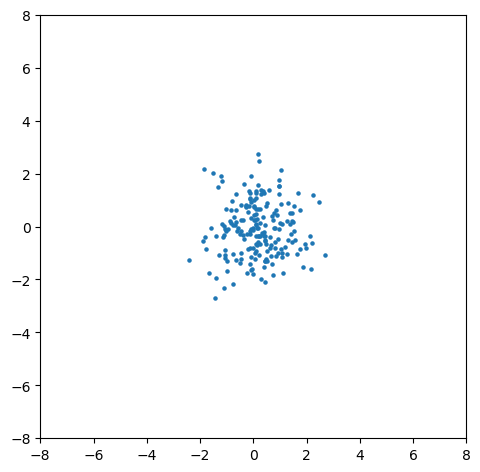

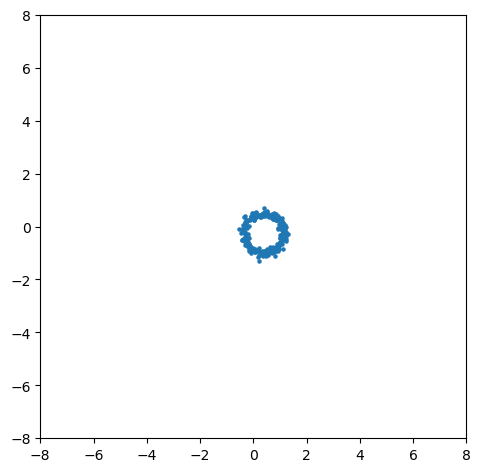

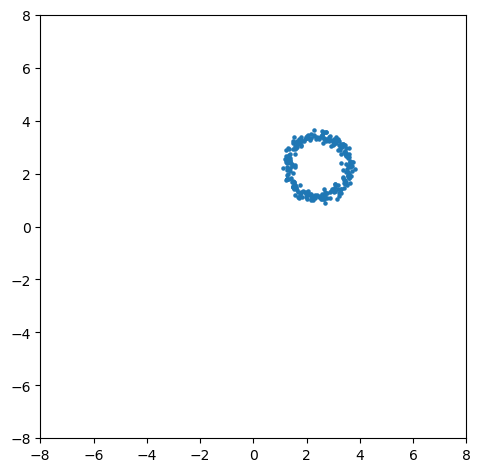

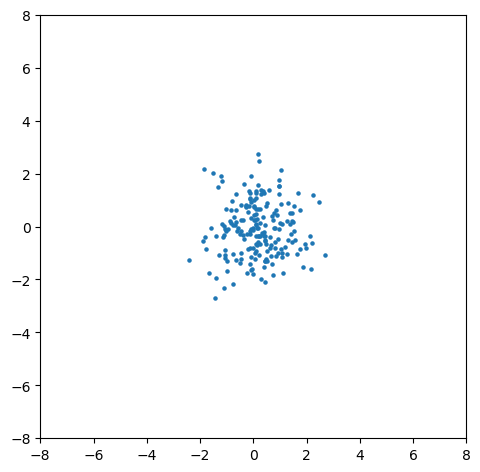

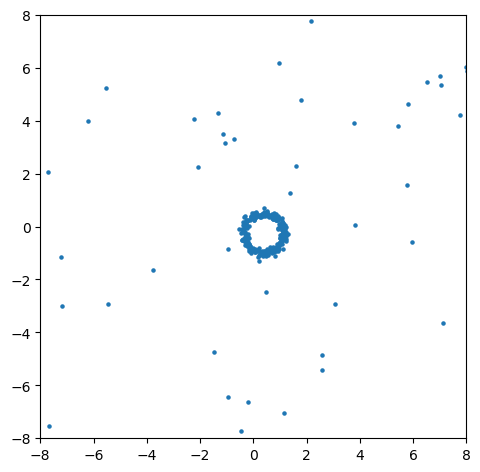

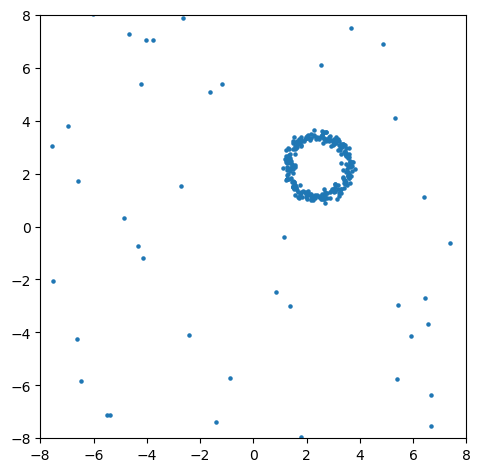

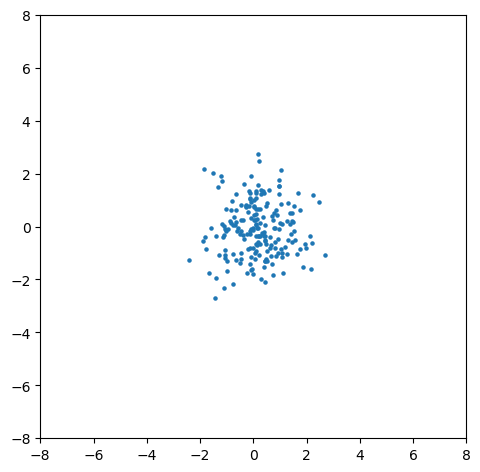

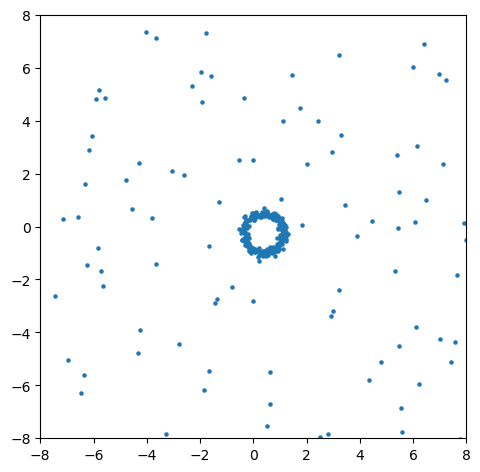

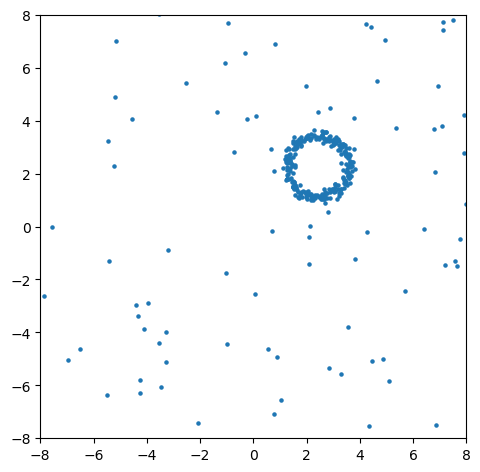

In [13]:
#load data
i=0
j=3
k=5
#print(X0)

for label in [0,0.05,0.1]:
    save_path='experiment/geodesic/result/'+str(label)
    X=data_list['X_'+str(label)]
    M=len(X)
    Xi=X[i].copy()
    Xj=X[j].copy()
    X0=data_list['X0'].copy()
    
    name='X0'
    plt.figure(1, figsize=(5.5,5.5))    
    plt.scatter(X0[:,0], X0[:,1], s=5, alpha=1)
    plt.xlim(-8,8)
    plt.ylim(-8,8)
    plt.savefig(save_path+'/'+name+'.pdf',dpi=200,format='pdf',bbox_inches='tight')
    plt.show()
        
    for k in [i,j]:
        Xk=X[k].copy()
        name='X'+str(k+1)
        plt.figure(1, figsize=(5.5,5.5))
        
        plt.scatter(Xk[:,0], Xk[:,1], s=5, alpha=1)
        #plt.set_title('Xi',fontsize=14)
        plt.xlim(-8,8)
        plt.ylim(-8,8)
        plt.savefig(save_path+'/'+name+'.pdf',dpi=200,format='pdf',bbox_inches='tight')
        plt.show()

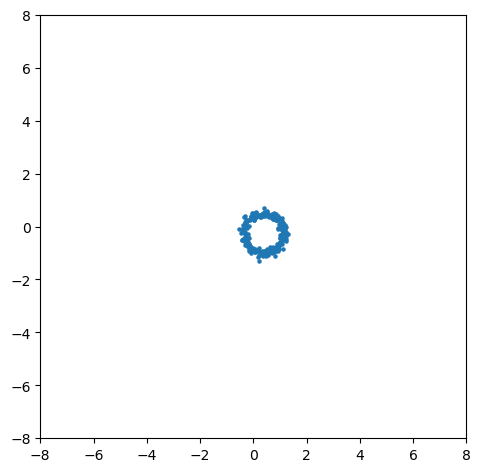

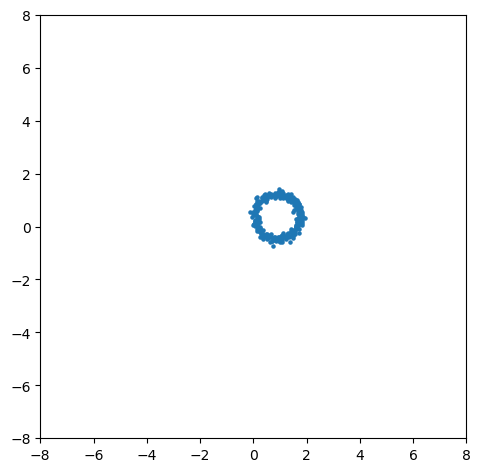

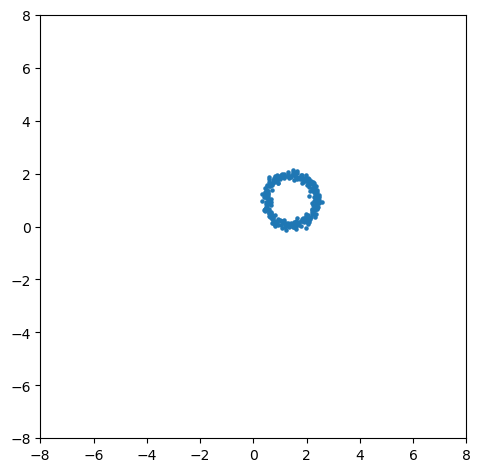

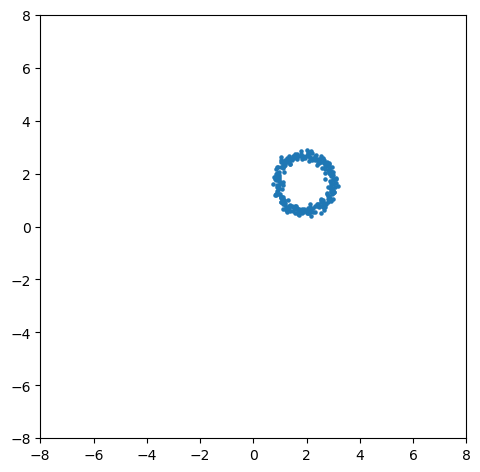

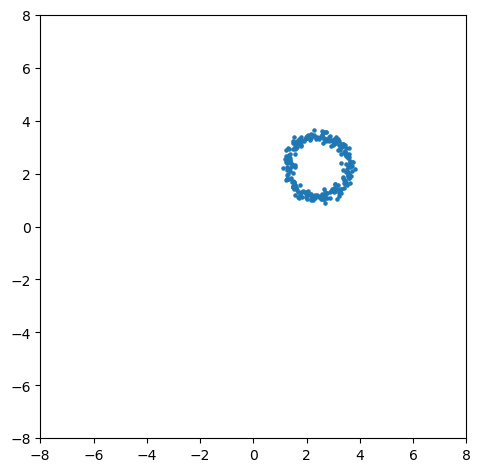

done


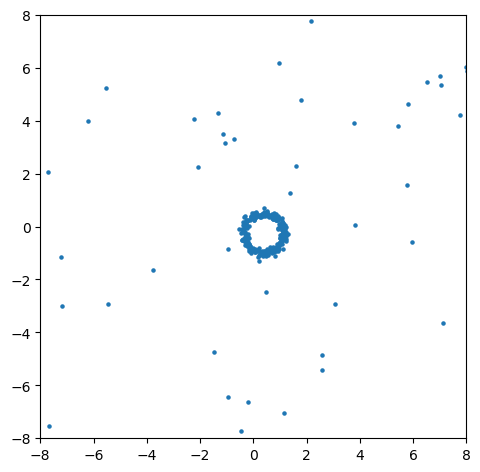

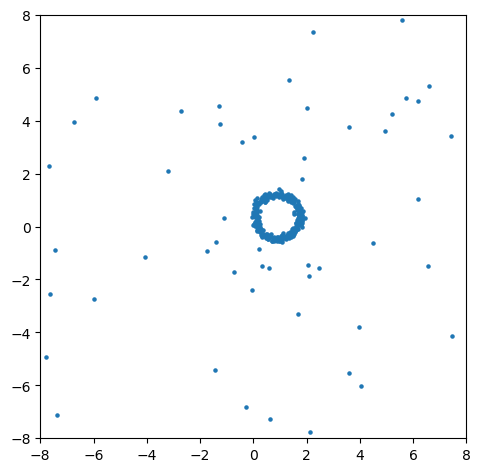

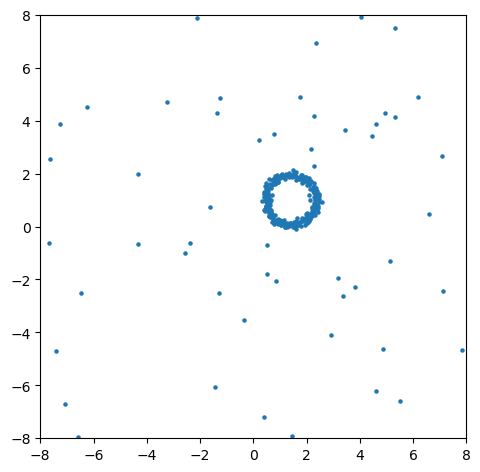

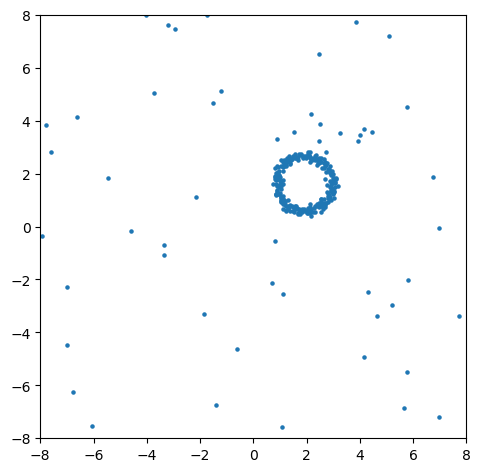

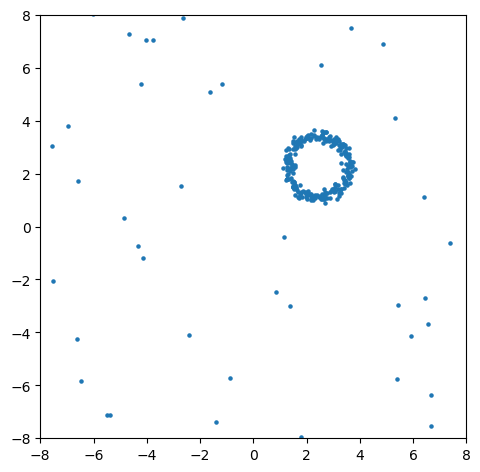

done


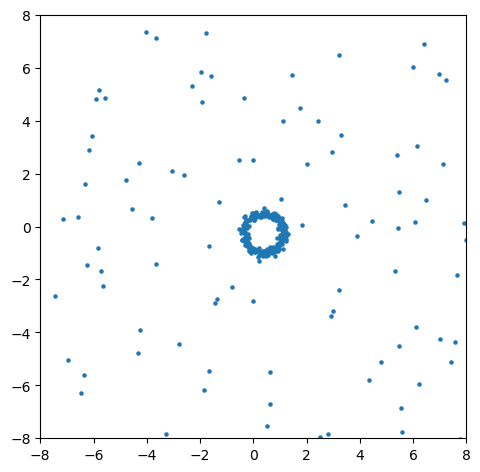

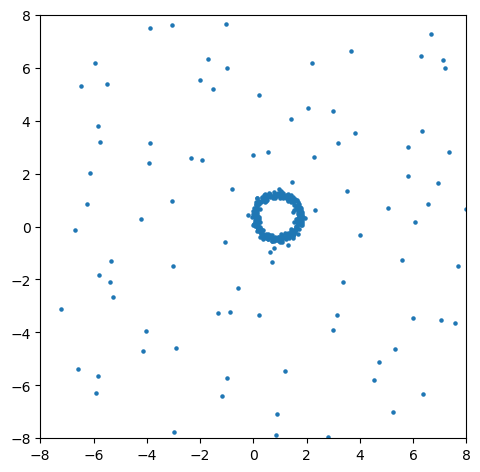

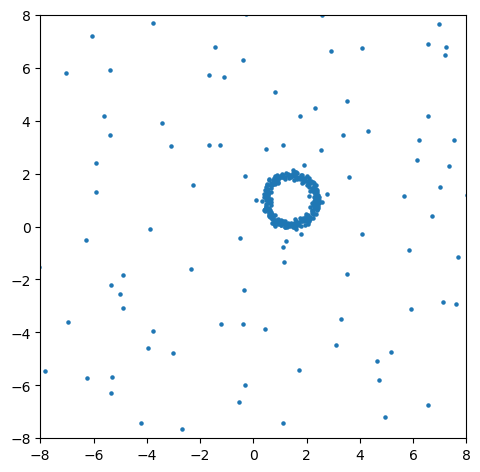

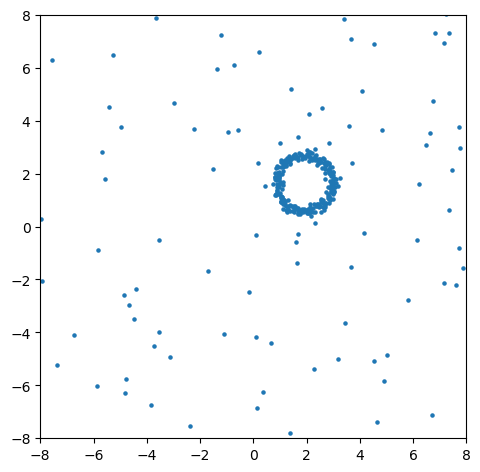

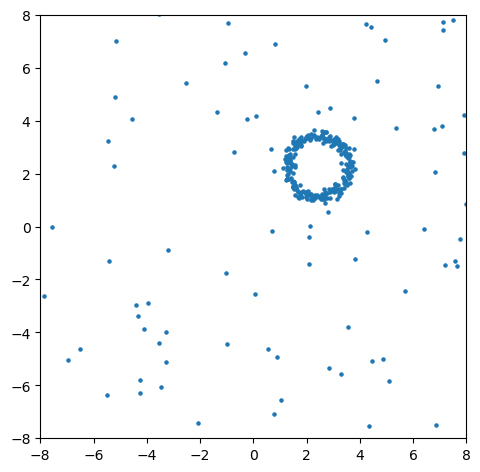

done


In [189]:
# OT geodesic
k=4
i=0
j=3
#fig,ax=plt.subplots(1,k,figsize=(k*3,3))
for label in [0,0.05,0.1]: 
    save_path='experiment/geodesic/result/circle/'+str(label)
    X=data_list['X_'+str(label)]
    Xi=X[i].copy()
    Xj=X[j].copy()
    X0=data_list['X0'].copy()
    pi=np.ones(Xi.shape[0])/Xi.shape[0]
    pj=np.ones(Xj.shape[0])/Xj.shape[0]
    Uj=lot_embedding(Xi,Xj,pi,pj)
    Xt_list_ot=ot_geodesic(Xi,Uj,np.linspace(0,1,k))
    
    ind=0
    for t in np.linspace(0,1,k):
        Xt=Xt_list_ot[ind]
        name='X_ot_t='+str(t)
        plt.figure(1, figsize=(5.5,5.5))
        plt.scatter(Xt[:,0], Xt[:,1], s=5, alpha=1)
        plt.xlim([-8,8])
        plt.ylim([-8,8])
        plt.savefig(save_path+'/'+name+'.pdf',dpi=200,format='pdf',bbox_inches='tight')
        plt.show()
        ind+=1
    torch.save(Xt_list_ot,save_path+'/Xt_list_ot.pt')
    print('done')


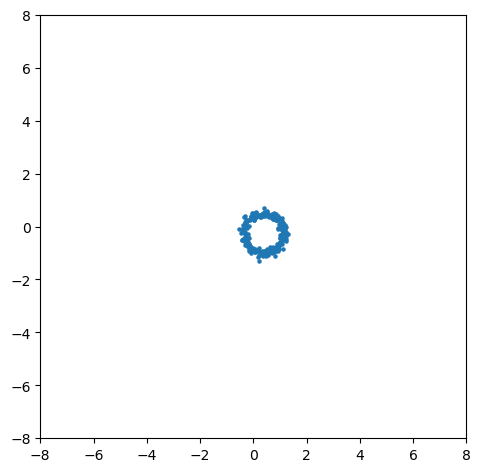

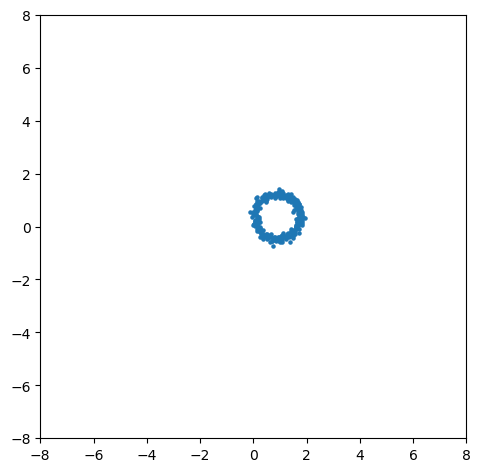

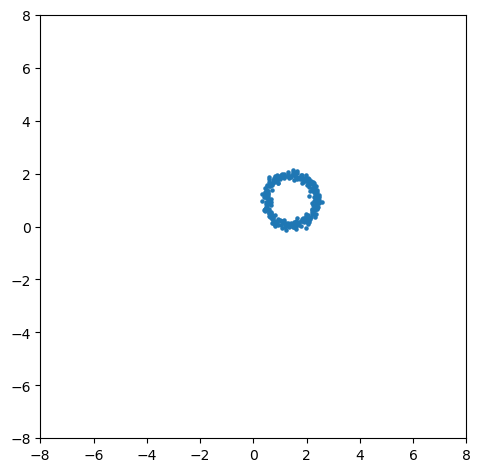

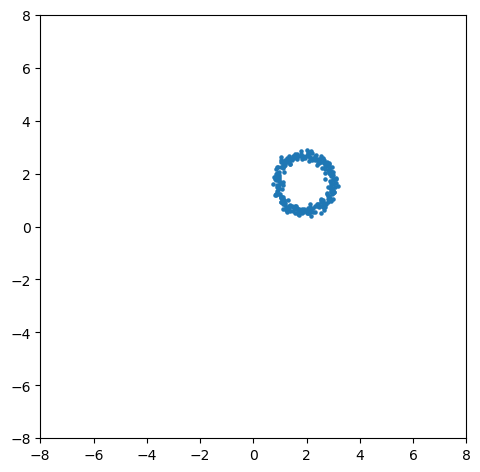

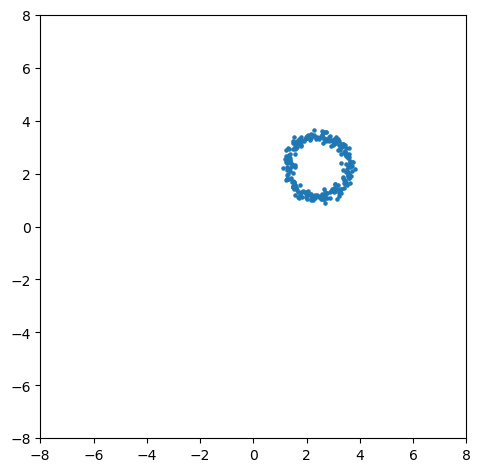

end


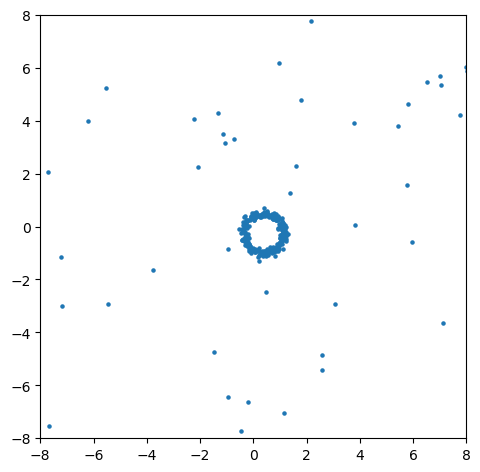

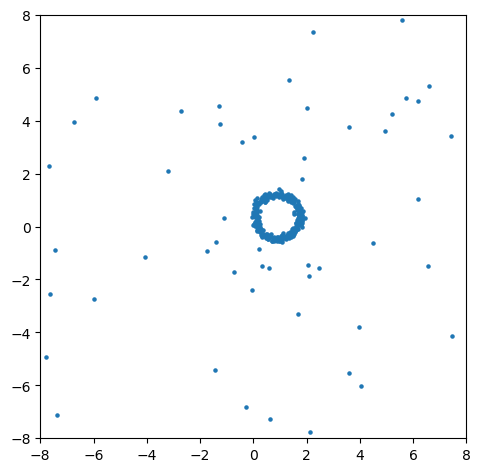

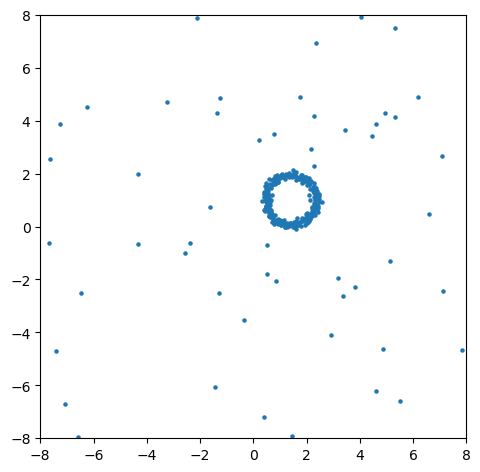

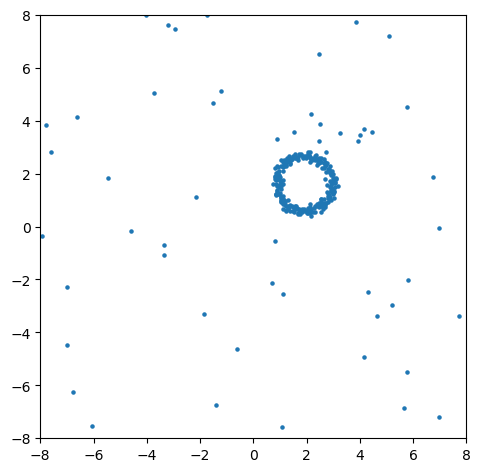

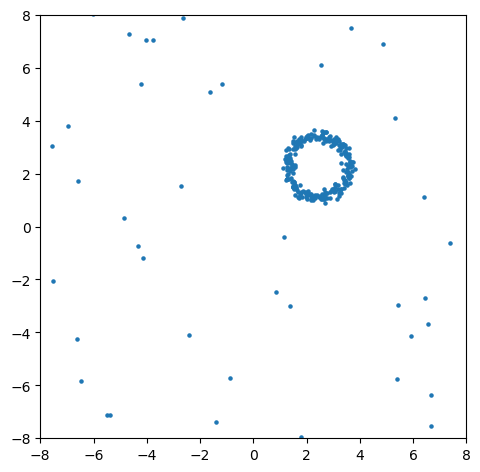

end


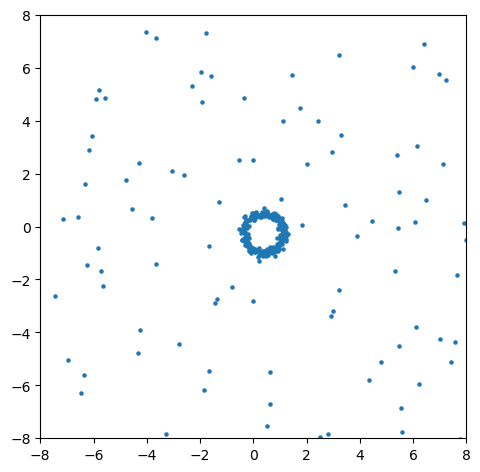

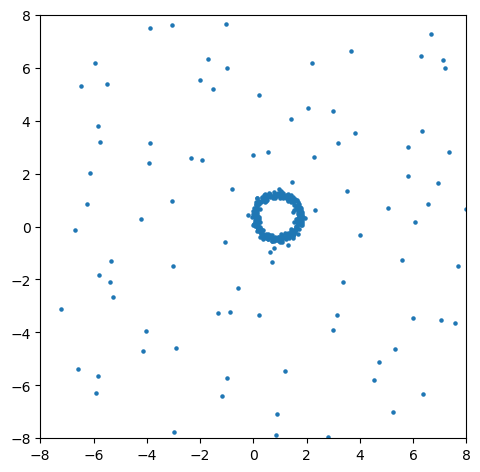

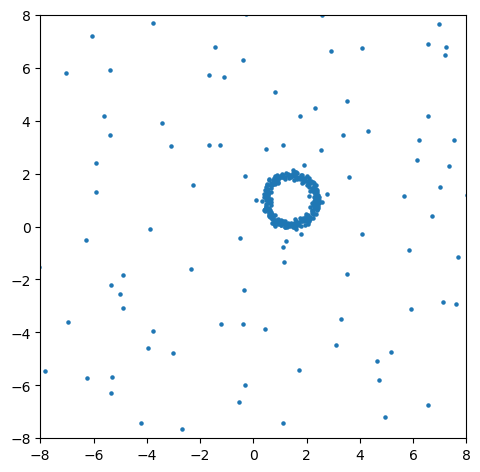

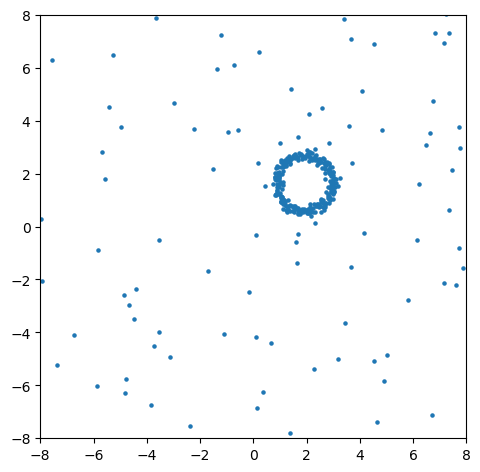

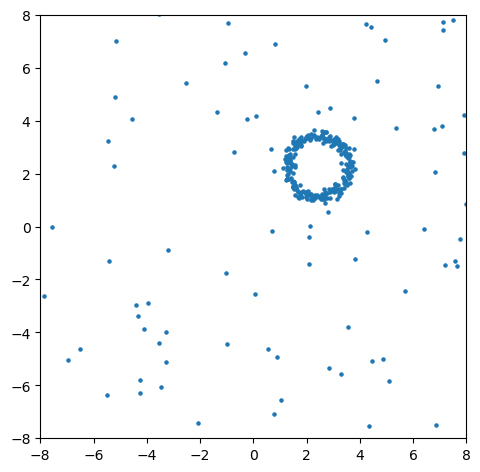

end


In [192]:
# LOT geodesic

for label in [0,0.05,0.1]: 
    save_path='experiment/geodesic/result/circle/'+str(label)
    X=data_list['X_'+str(label)]
    Xi=X[i].copy()
    Xj=X[j].copy()
    X0=data_list['X0'].copy()
    U_lot=list()
    M=len(X)
    for k in range(M):
        X0=X[0].copy()
        Xk=X[k].copy()
        N0=X0.shape[0]
        Nk=Xk.shape[0]
        p0=np.ones(N0)/N0
        pk=np.ones(Nk)/Nk
        Uk_lot=lot_embedding(X0,Xk,p0,pk)
        U_lot.append(Uk_lot)
    torch.save(U_lot,save_path+'/U_lot.pt')

    k=4
    Ui=U_lot[i]
    Uj=U_lot[j]
    
    #X_alpha=lot_geodesic(X0,Ui,Uj,alpha)
    
    Xt_list_lot=lot_geodesic(X0,Ui,Uj,np.linspace(0,1,5))
    ind=0
    for t in np.linspace(0,1,5):
        Xt=Xt_list_lot[ind]
        plt.figure(1, figsize=(5.5,5.5))
        name='X_lot_t='+str(t)
        plt.scatter(Xt[:,0], Xt[:,1], s=5, alpha=1)
        plt.xlim(-8,8)
        plt.ylim(-8,8)
        plt.savefig(save_path+'/'+name+'.pdf',dpi=200,format='pdf',bbox_inches='tight')
        plt.show()
        ind+=1   
    torch.save(Xt_list_lot,save_path+'/Xt_list_lot.pt')
     
        #print(save_path+'/U_ot.pt')
    print('end')


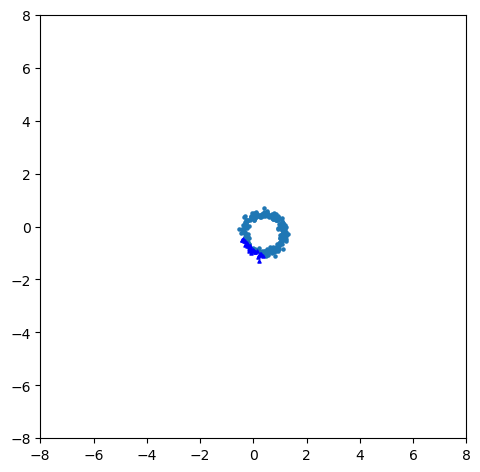

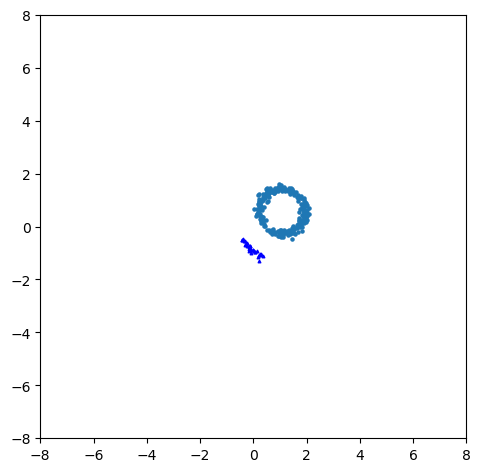

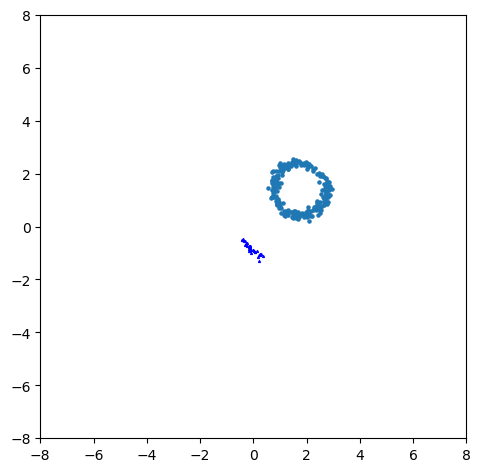

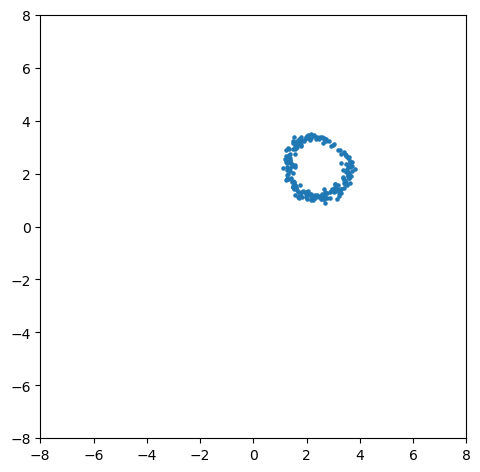

end


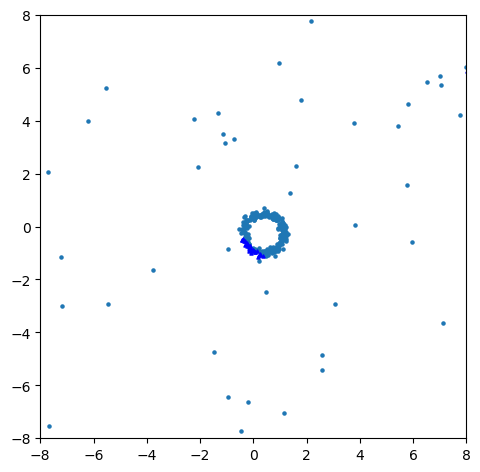

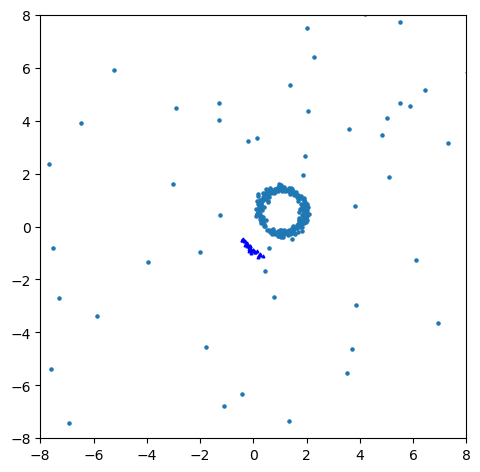

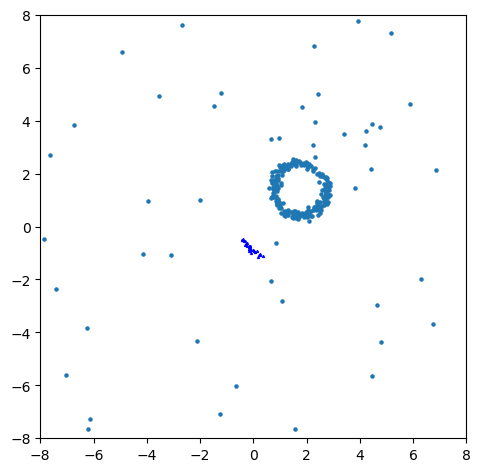

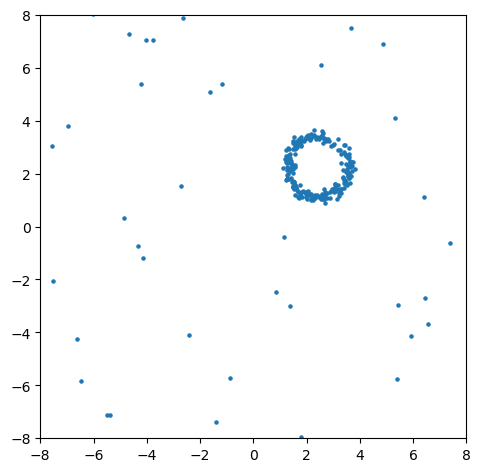

end


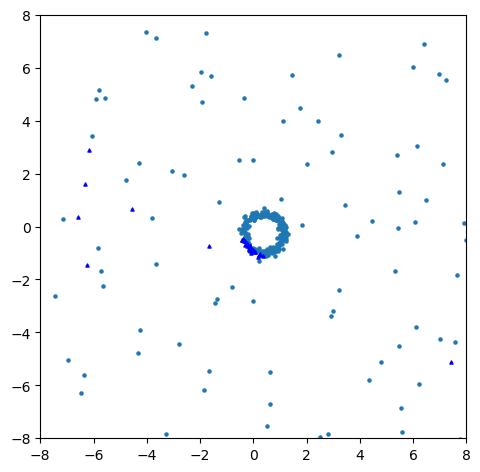

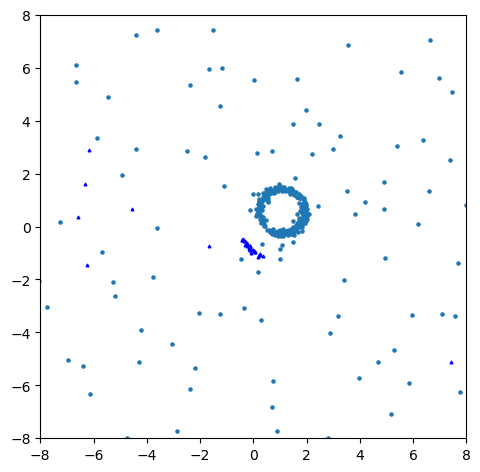

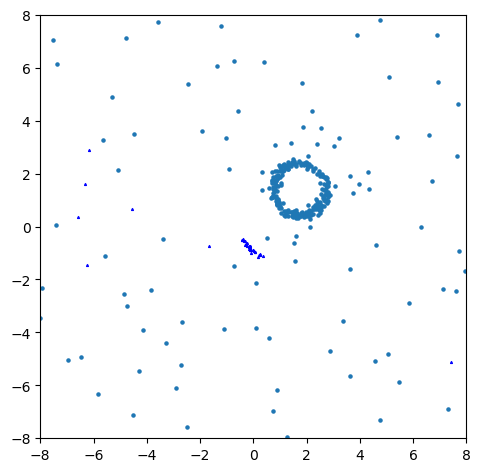

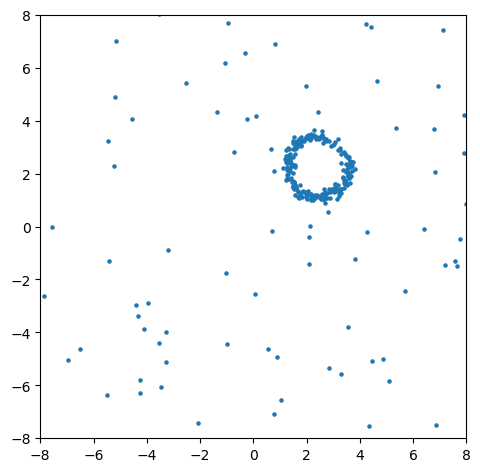

end


In [196]:
# opt interpolation 

for label in [0,0.05,0.1]: 
    save_path='experiment/geodesic/result/circle/'+str(label)
    X_0=data_list['X_0']
    X0i=X_0[i]
    X0j=X_0[j]
    N0i=X0i.shape[0]
    N0j=X0j.shape[0]
    
    X=data_list['X_'+str(label)]
    Xi=X[i].copy()
    Xj=X[j].copy()
    X0=X[0].copy()
    U_ot=list()

    Ni=Xi.shape[0]
    Nj=Xj.shape[0]
    pi=np.ones(Ni)/N0i
    pj=np.ones(Nj)/N0j
    Lambda=10

    Uj,pj_hat,Mj=lopt_embedding(Xi,Xj,pi,pj,Lambda)
    Xt_list,X_d=opt_geodesic(Xi,Uj,pi,pj_hat,np.linspace(0,1,k))
    ind=0
    for t in np.linspace(0,1,k): 
        Xt=Xt_list[ind]
        plt.figure(1, figsize=(5.5,5.5))
        name='X_opt_t='+str(t)
        plt.scatter(Xt[:,0], Xt[:,1], s=5, alpha=1)
        plt.scatter(X_d[:,0], X_d[:,1],c='b',marker='^', s=5*(1-t), alpha=1)
        plt.xlim(-8,8)
        plt.ylim(-8,8)
        plt.savefig(save_path+'/'+name+'.pdf',dpi=200,format='pdf',bbox_inches='tight')
        plt.show()
        ind+=1

    torch.save(Xt_list,save_path+'/X_opt_alpha.pt')
    print('end')
    # X_alpha=opt_geodesic(Xi,Xj,p1,p2,Lambda,alpha)
    # ax[i].scatter(X_alpha[:,0],X_alpha[:,1],s=5,alpha=1)
    # ax[i].set_title(r'$\alpha=$%.02f'%alpha,fontsize=14)
    # ax[i].set_xlim(-8,8)
    # ax[i].set_ylim(-8,8)

#i=k
#ax[i].scatter(X_alpha[:,0],X_alpha[:,1],s=5,alpha=1)
#ax[i].set_title(r'$\alpha=$%.02f'%alpha,fontsize=14)
#ax[i].set_xlim(-6,6)
#ax[i].set_ylim(-6,6)    
#fig.text(0.5, -0.05, 'Transport Geodesic, OPT', ha='center',fontsize=14)
#plt.show()

In [ ]:
# LOPT interpolation 
Lambda=30.0
X0=data_list['X0'].copy()
N0=X0.shape[0]
p0=np.ones(N0)/N0
for label in [0,0.05,0.1]: 
    save_path='experiment/geodesic/result/circle'+str(label)
    X_0=data_list['X_0']
    X=data_list['X_'+str(label)]
    opt_embedding=list()

    for k in range(M):
        X0k=X_0[k]
        N0k=X0k.shape[0]
        Xk=X[k].copy()
        Nk=Xk.shape[0]
        
        pk=np.ones(Nk)/N0k
        Uk,pk_hat,Mk=lopt_embedding(X0,Xk,p0,pk,Lambda)
        opt_embedding.append((Uk,pk_hat))
        
    torch.save(opt_embedding,save_path+'/opt_embedding.pt')
    #print(save_path+'/U_opt.pt')

    (Ui,pi_hat)=opt_embedding[i]
    (Uj,pj_hat)=opt_embedding[j]
    Xt_list_lopt,X_d,X_c=lopt_geodesic(X0,Ui,Uj,pi_hat,pj_hat,np.linspace(0,1,5))

    
    ind=0
    for t in np.linspace(0,1,5):
        Xt=Xt_list_lopt[ind]
        plt.figure(1, figsize=(5.5,5.5))
        name='X_lopt_t='+str(t)
        plt.scatter(Xt[:,0], Xt[:,1], s=5, alpha=1)
        plt.scatter(X_d[:,0], X_d[:,1],color='b',marker='^', s=5*(1-t), alpha=1)
        plt.scatter(X_c[:,0], X_c[:,1],color='b',marker='^', s=5*(t), alpha=1)

        plt.xlim(-8,8)
        plt.ylim(-8,8)
        plt.savefig(save_path+'/'+name+'.pdf',dpi=200,format='pdf',bbox_inches='tight')
        plt.show()
        ind+=1
    print('end')

RuntimeError: Parent directory experiment/geodesic/result/circle0 does not exist.

In [91]:
# simple example
X0=np.array([-1.0,.0])
p0=np.array([0.5,0.5])
X1=np.array([2.0,3.0])
p1=np.array([0.5,0.5])
Lambda=3
tN=4
t_list=np.linspace(0,1,tN)

save_path='/experiment/geodesic/example'

In [166]:
# HK geodesic 
def cost_hk(x,y):
    s=1/np.sqrt(2)
    cost=s*np.linalg.norm(x-y)
    return cost

def phi_hk(cost,m0,m1,t):
    if t==0 or m1==0:
        return 0
    elif t==1 or m0==0:
        return cost
    elif t<1 and t>0:
        return np.arccos(((1-t)*np.sqrt(m0)+t*np.sqrt(m1)*np.cos(cost))/np.sqrt(M(cost,m0,m1,t)))
        
def M_hk(cost,m0,m1,t):
    return (1-t)**2*m0+t**2*m1+2*t*(1-t)*np.sqrt(m0*m1)*np.cos(cost)

def X_hk(x0,x1,m0,m1,t):
    cost_hk=cost_hk(x0,x1)
    return x0+(x1-x0)*phi_hk(cost_hk,m0,m1,t)/cost_hk

def HK_geodesic_T(X0,X1,p0,p1,T,t_list):
    N0,d=X0.shape
    N1=X1.shape[0]
    D0=np.arange(N0)
    D0_trans=D0[T>=0]
    D0_perp=D0[T<0]
    
    D1=np.arange(N1)

    D1_trans=T[D0_trans]
    mask = np.in1d(D1,D1_trans)
    D1_perp=D1[np.invert(mask)]
    
    X0_trans=X0[D0_trans]
    X1_trans=X1[D1_trans]
    p0_trans=p0[D0_trans]
    p1_trans=p1[D1_trans]
    Tn=t_list.shape[0]
    Xt_list=np.zeros((Tn,D0_trans.shape[0],d))
    Mt_list=np.zeros((Tn,D0_trans.shape[0]))
    i_t=0
    for t in t_list:
        i_loc=0
        for (x0,x1,m0,m1) in zip(X0_trans,X1_trans,p0_trans,p1_trans):
            cost=cost_hk(x0,x1)
            Xt_list[i_t,i_loc]=X(x0,x1,m0,m1,t)
            Mt_list[i_t,i_loc]=M(cost,m0,m1,t)
            i_loc+=1
        i_t+=1
    X_d=X0[D0_perp]
    p0_perp=p0[D0_perp]
    X_c=X1[D1_perp]
    p1_perp=p1[D1_perp]
    return Xt_list,Mt_list,X_d,X_c,p0_perp,p1_perp

                         


    
                         
    
    

In [176]:
#opt interporlation

def opt_interpolation_T(X0,X1,p0,p1,T,t_list):
    N0,d=X0.shape
    N1=X1.shape[0]
    D0=np.arange(N0)
    D0_trans=D0[T>=0]
    D0_perp=D0[T<0]
    D1=np.arange(N1)
    D1_trans=T[D0_trans]
    mask = np.in1d(D1,D1_trans)
    D1_perp=D1[np.invert(mask)]
    X0_trans=X0[D0_trans]
    X1_trans=X1[D1_trans]
    

    p0_trans=np.zeros(N0)
    p1_trans=np.zeros(N1)
    p01_trans_take=np.minimum(p0[D0_trans],p1[D1_trans])
    p0_trans[D0_trans]=p01_trans_take
    p1_trans[D1_trans]=p01_trans_take
    Xt_list=np.zeros((Tn,D0_trans.shape[0],d))
    i_t=0
    for t in t_list:
        Xt_list[i_t]=(1-t)*X0_trans+t*X1_trans
        i_t+=1
        
    p0_remain=p0-p0_trans
    p1_remain=p1-p1_trans
    D0_remain=p0_remain>0
    D1_remain=p1_remain>0
    X_d=X0[D0_remain]
    X_c=X1[D1_remain]
    p0_remain_take=p0_remain[D0_remain]
    p1_remain_take=p1_remain[D1_remain]

    return Xt_list,p01_trans_take,X_d,X_c,p0_remain_take,p1_remain_take


In [168]:
T=np.array([-1,0])
X0_d=X0.reshape((2,1))
X1_d=X1.reshape((2,1))

N0,d=X0_d.shape
N1=X1_d.shape[0]
D0=np.arange(N0)
D0_trans=D0[T>=0]
D0_per=D0[T<0]

# D1=np.arange(N1)

# D1_trans=T[D0_trans]
# mask = np.in1d(D1,D1_trans)
# D1_per=D1[np.invert(mask)]

# X0_trans=X0[D0_trans]
# X1_trans=X1[D1_trans]
# p0_trans=p0[D0_trans]
# p1_trans=p1[D1_trans]
# Tn=t_list.shape[0]
# Xt_list=np.zeros((Tn,D0_trans.shape[0],d))
# Mt_list=np.zeros((Tn,D0_trans.shape[0]))
# i_t=0

# for t in t_list:
#     i_loc=0
#     for (x0,x1,m0,m1) in zip(X0_trans,X1_trans,p0_trans,p1_trans):
#         cost_hk=cost_HK(x0,x1)
#         Xt_list[i_t,i_loc]=X(x0,x1,m0,m1,t)
#         Mt_list[i_t,i_loc]=M(cost_hk,m0,m1,t)
#         i_loc+=1
#     i_t+=1
# X_d=X0[D0_per]
# p0_per=p0[D0_per]
# X_c=X1[D1_per]
# p1_per=p1[D1_per]
    

#HK_geodesic_dirac(X0_d,X1_d,p0,p1,T,t_list)

In [127]:

fig = plt.figure()
ax = plt.subplot(111)
for K in [2,4]:
    print('K,',K)
    save_dict2=torch.load('experiment/performance/cost_list_K'+str(K)+ '.pt')
    for Lambda in Lambda_list:
        print('Lambda,',Lambda)
        opt_cost1=save_dict2['Lambda'+str(Lambda)]['opt_cost1']
        opt_cost2=save_dict2['Lambda'+str(Lambda)]['opt_cost2']
    #   opt_cost3=save_dict['Lambda'+str(Lambda)]['opt_cost3']

        relative_error1=(np.abs(opt_cost2-opt_cost1)/opt_cost1).mean(2)
        relative_error1_mean=relative_error1.mean(1)
        relative_error1_std=relative_error1.std(1)
        #relative_error2=np.abs(opt_cost3-opt_cost1)/opt_cost1
        #relative_error2_mean=relative_error2.mean(1)
        #relative_error2_std=relative_error2.std(1)

        plt.plot(n_list,relative_error1_mean,'-',label='K='+str(K)+'Lambda='+str(Lambda))
        plt.fill_between(n_list,relative_error1_mean-1*relative_error1_std,relative_error1_mean+1*relative_error1_std,alpha=0.3)
        #plt.plot(n_list,relative_error2_mean,'-',label='b,Lambda='+str(Lambda))
        #plt.fill_between(n_list,relative_error2_mean-1*relative_error2_std,relative_error2_mean+1*relative_error2_std,alpha=0.3)


plt.xlabel("n: size of X")
plt.ylabel("relative error")
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,box.width, box.height * 0.9])
plt.legend(loc='upper center',bbox_to_anchor=(0.5, 1.13),
          fancybox=True, shadow=True, ncol=3)
plt.savefig('experiment/performance/error_K='+str(K)+'.pdf',format="pdf",dp1=800,bbox_inches='tight')
plt.show()
print('done')

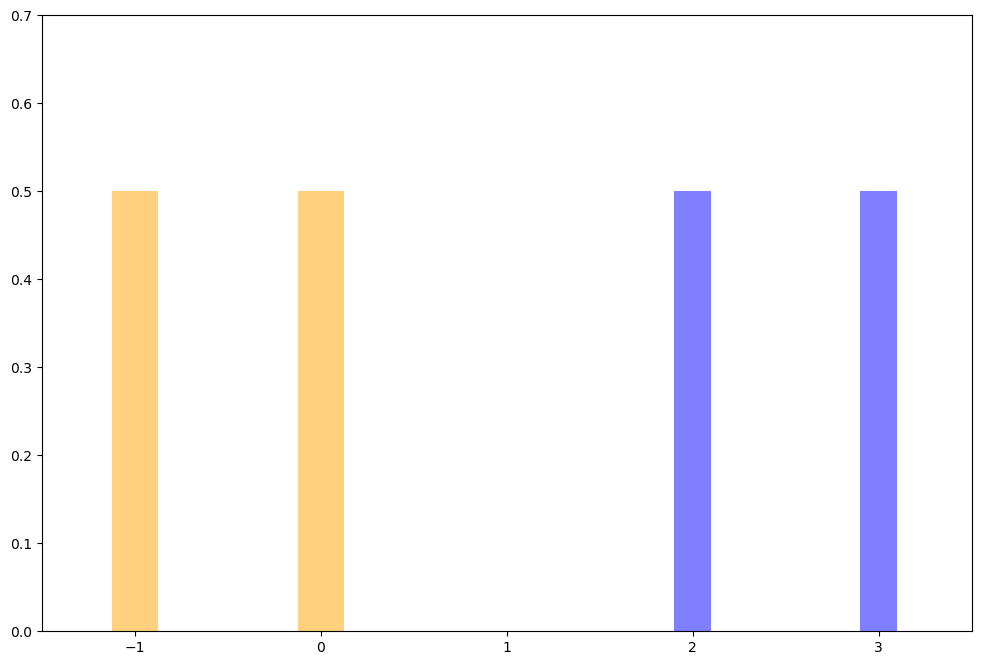

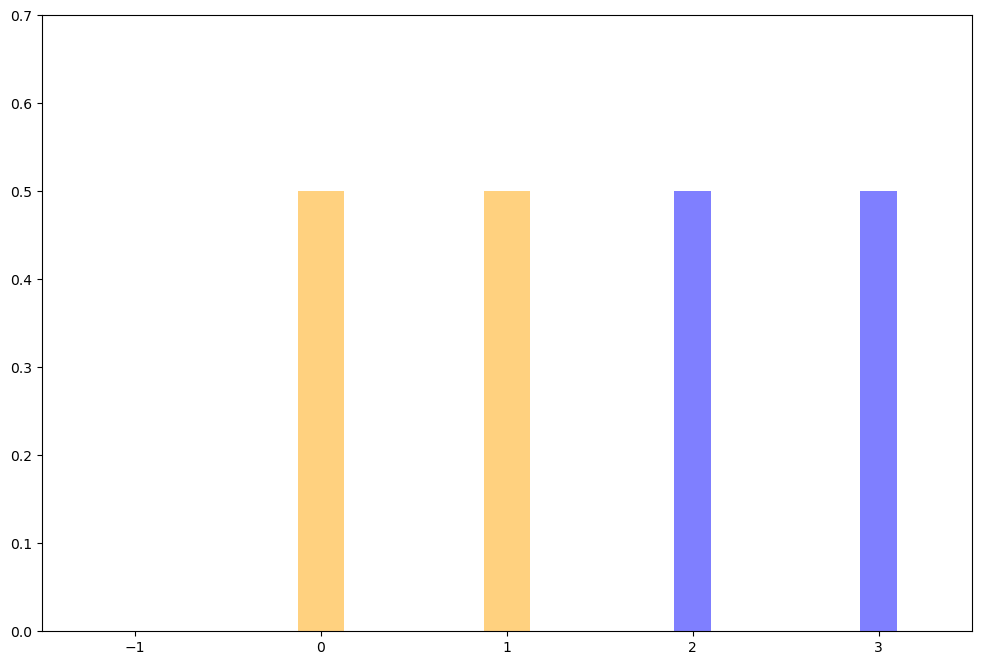

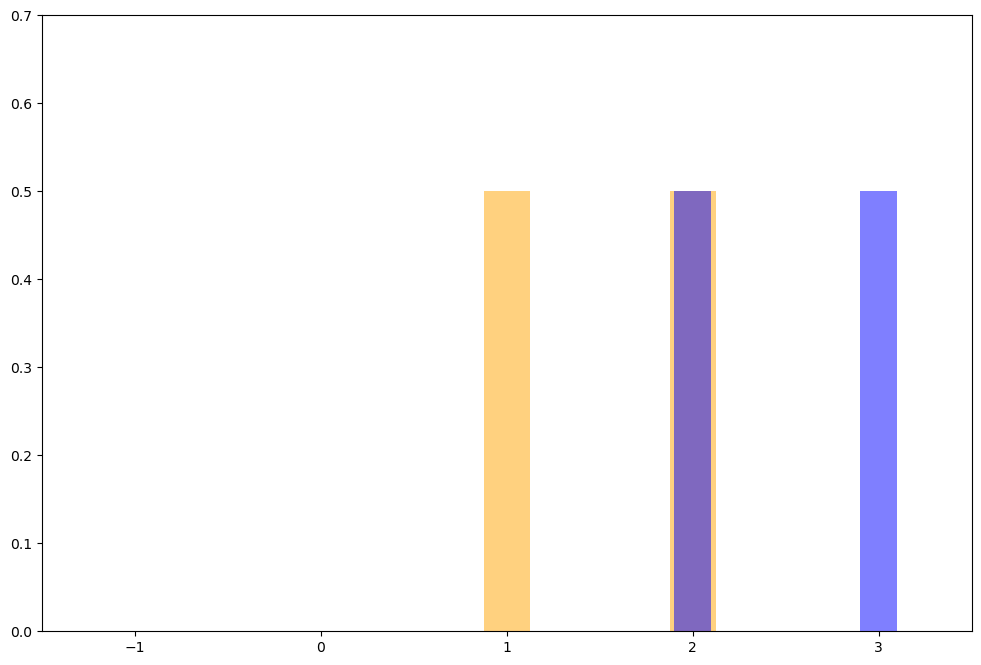

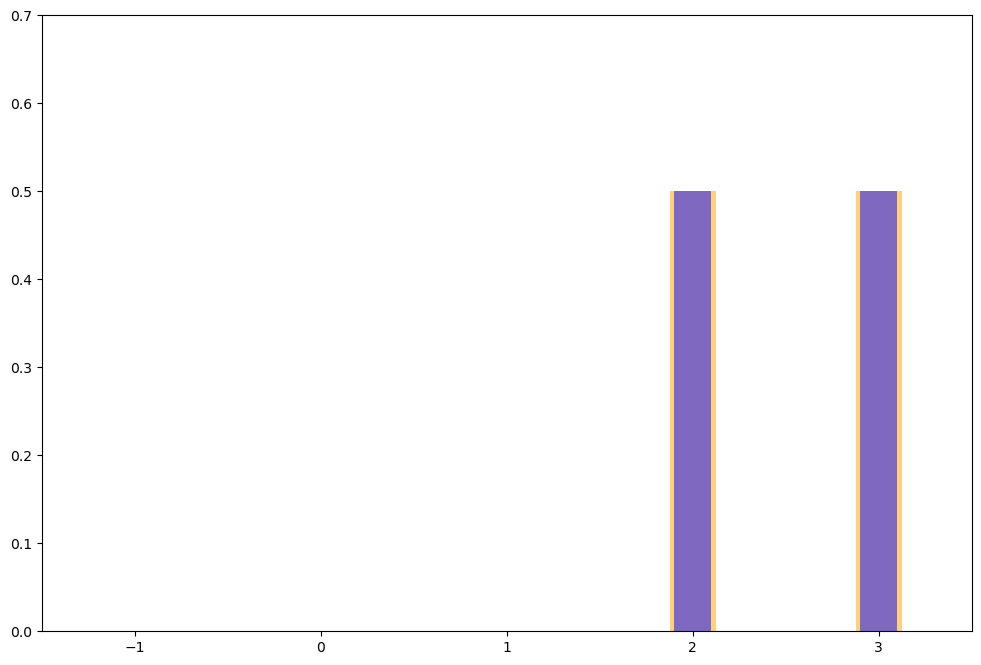

In [182]:
#OT geodesic
X0_d=X0.reshape((2,1))
X1_d=X1.reshape((2,1))
U1=lot_embedding(X0_d,X1_d,p0,p1)
Xt_list_ot=ot_geodesic(X0_d,U1,t_list)
barWidth = 0.25
for ind in range(tN):
    t=t_list[ind]
    Xt=Xt_list_ot[ind]
    Xt=Xt.reshape((2,))
    name='X_ot_t='+str(t)
    fig = plt.subplots(figsize =(12, 8))
    #plt.bar(br1, IT, color ='r', width = barWidth,
        #edgecolor ='grey', label ='IT')
    #fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5)) 
    # discrete plot 
    plt.bar(Xt,p0,color='orange',width = 0.25,alpha=0.5)
    plt.bar(X1,p1,color='blue',width =0.2,alpha=0.5)
    #ax[0].bar(X1,p1)
    
    plt.xlim([-1.5, 3.5])
    plt.ylim([0, 0.7])
    plt.savefig('experiment/geodesic/result/sample/'+name+'.pdf',dpi=200,format='pdf',bbox_inches='tight')
    plt.show()   

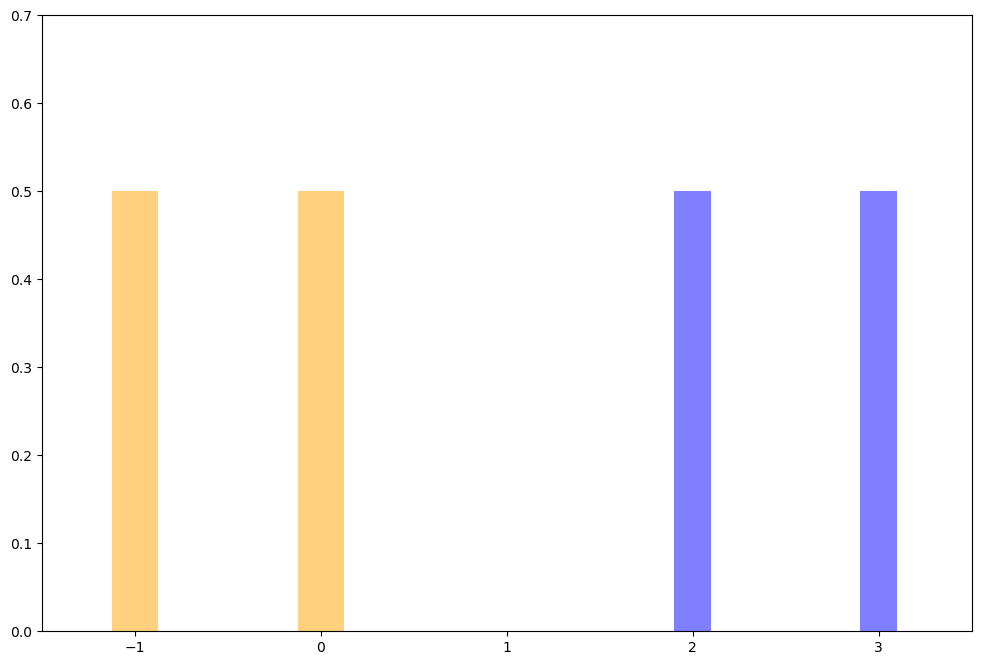

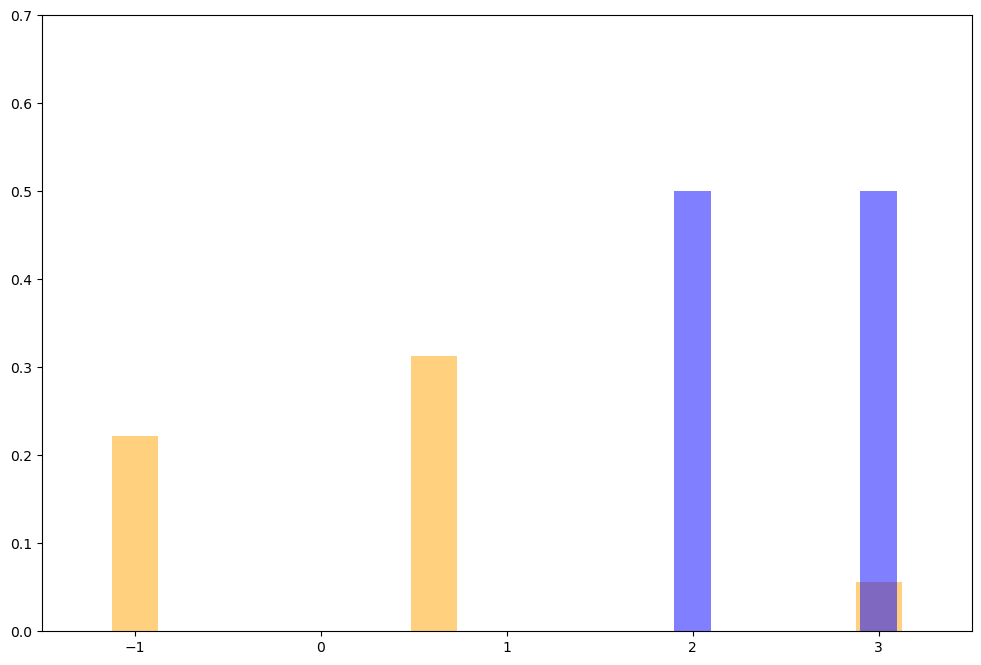

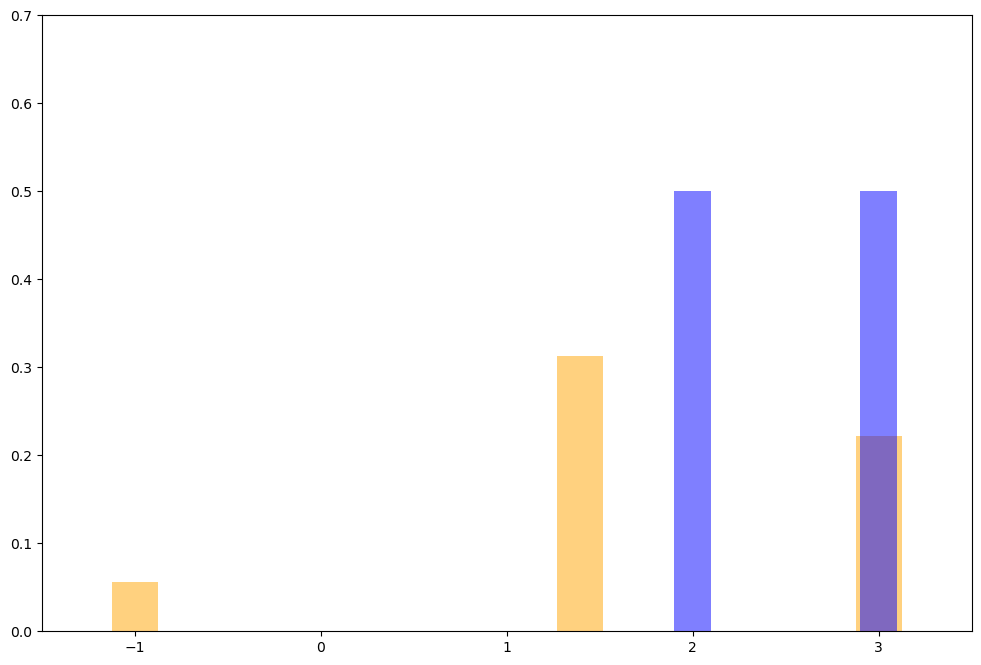

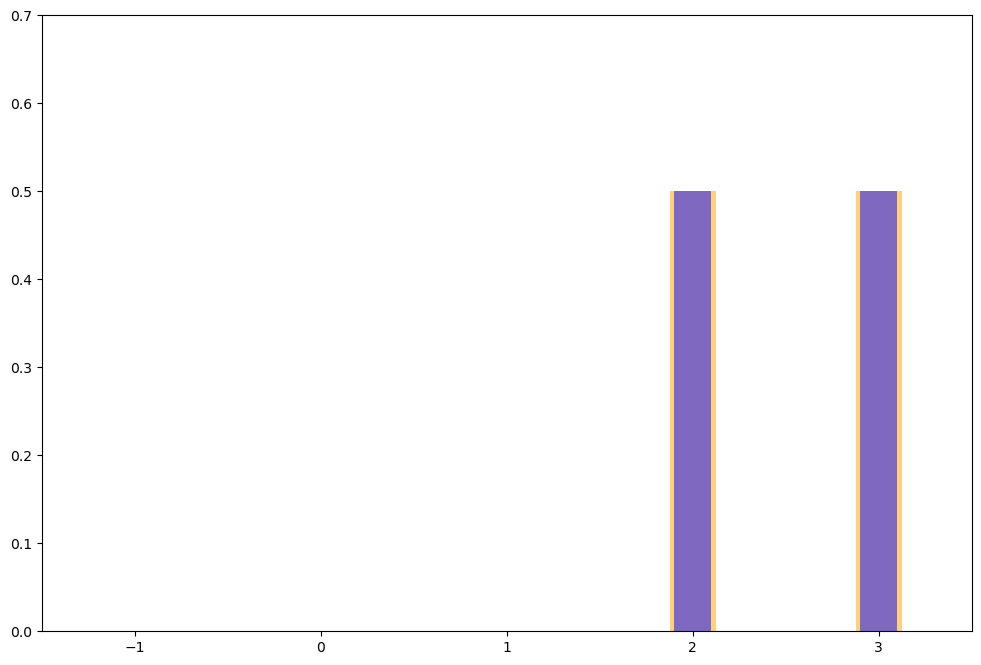

In [183]:
# Dirac HK geodesic
T=np.array([-1,0])
X0_d=X0.reshape(X0.shape[0],1)
X1_d=X1.reshape(X1.shape[0],1)

Xt_list,Mt_list,X_d,X_c,p0_perp,p1_perp=HK_geodesic_T(X0_d,X1_d,p0,p1,T,t_list)
X_d=X_d.reshape(X_d.shape[0])
X_c=X_c.reshape(X_c.shape[0])
ind=0
for ind in range(tN):
    t=t_list[ind]
    Xt=Xt_list[ind]
    Mt=Mt_list[ind]
    Xt=Xt.reshape(Xt.shape[0])
    name='X_hk_t='+str(t)
    fig = plt.subplots(figsize =(12, 8))
    
    plt.bar(Xt,Mt,color='orange',width = 0.25,alpha=0.5)
    plt.bar(X_d,(1-t)**2*p0_perp,color='orange',width = 0.25,alpha=0.5)
    plt.bar(X_c,t**2*p1_perp,color='orange',width = 0.25,alpha=0.5)
    
    plt.bar(X1,p1,color='blue',width =0.2,alpha=0.5)
    #ax[0].bar(X1,p1)
    
    plt.xlim([-1.5, 3.5])
    plt.ylim([0, 0.7])
    plt.savefig('experiment/geodesic/result/sample/'+name+'.pdf',dpi=200,format='pdf',bbox_inches='tight')
    plt.show()
    ind+=1
    


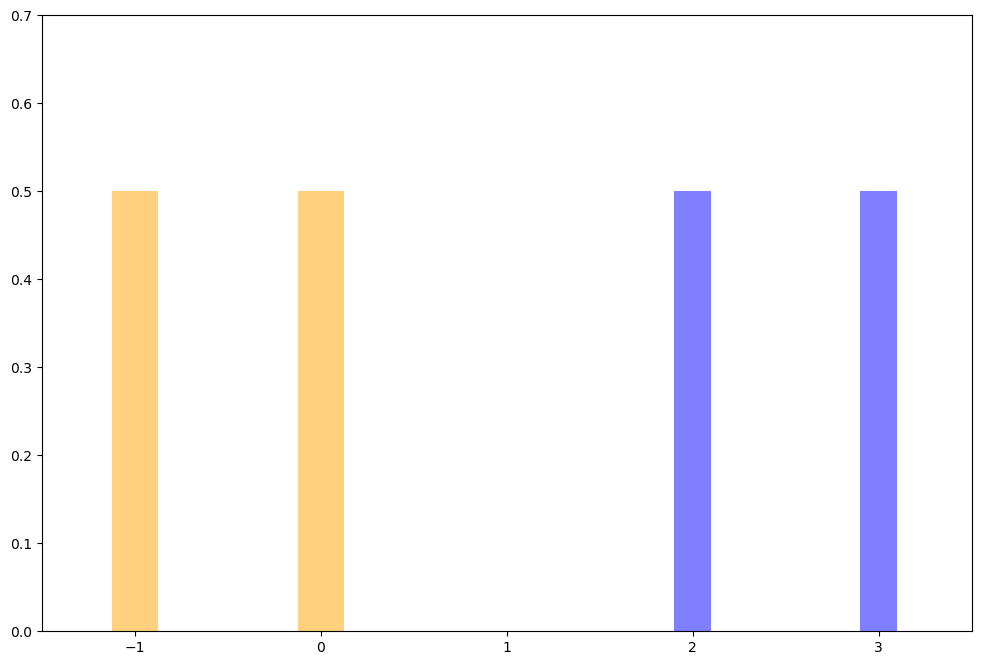

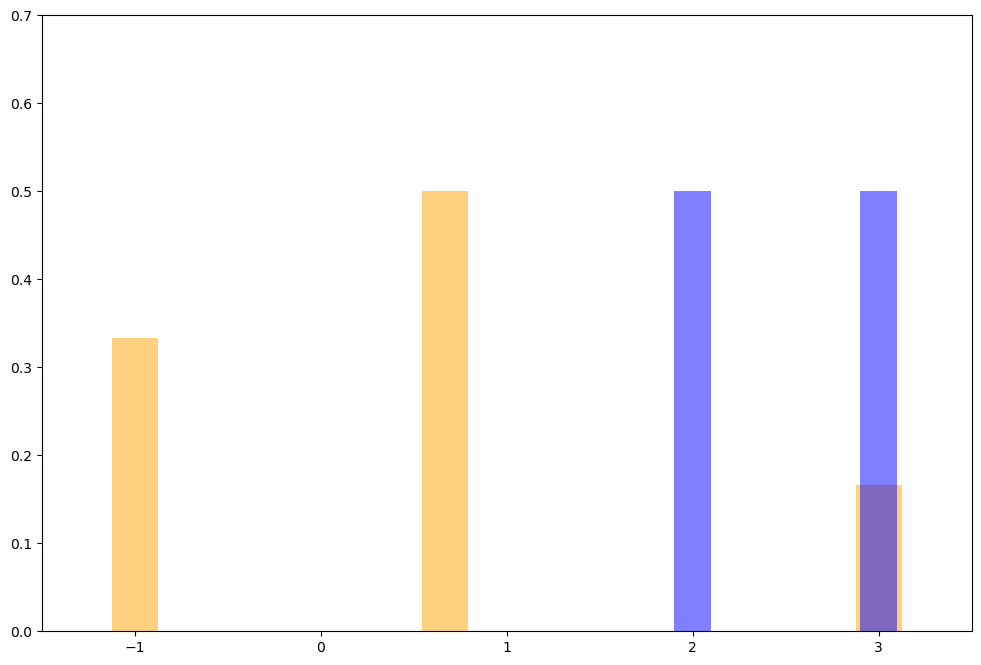

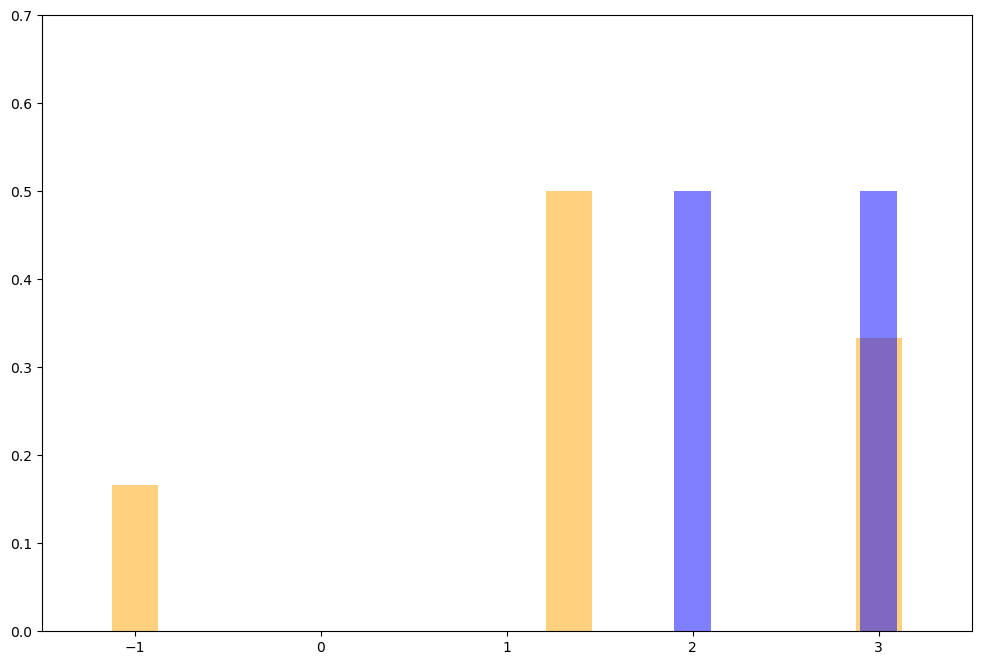

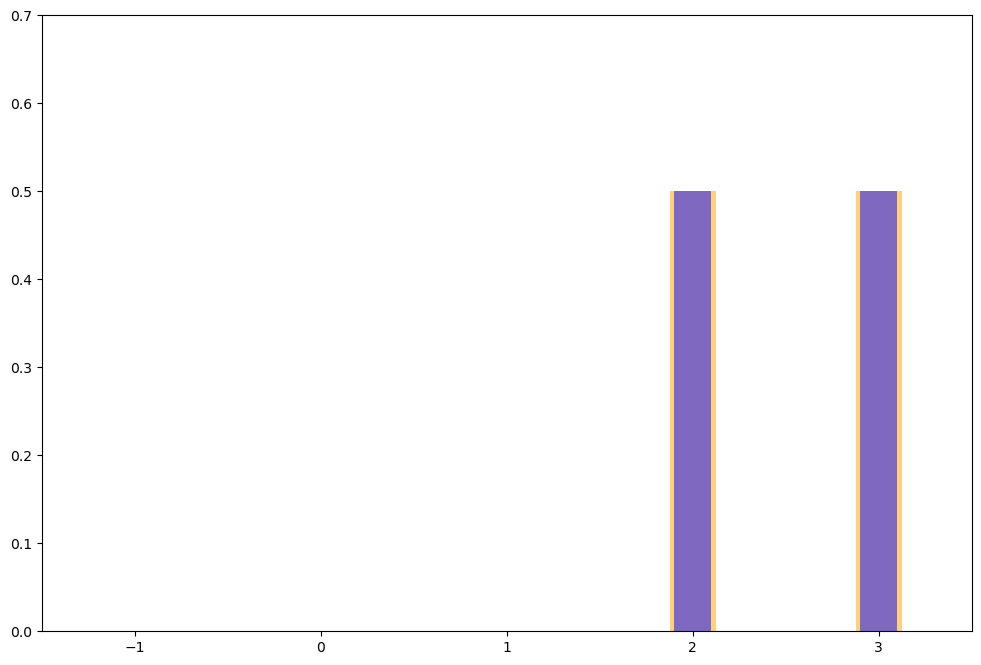

In [185]:
# Dirac opt interpolation
T=np.array([-1,0])
X0_d=X0.reshape(X0.shape[0],1)
X1_d=X1.reshape(X1.shape[0],1)

Xt_list,p01_trans_take,X_d,X_c,p0_remain,p1_remain=opt_interpolation_T(X0_d,X1_d,p0,p1,T,t_list)
X_d=X_d.reshape(X_d.shape[0])
X_c=X_c.reshape(X_c.shape[0])
ind=0
for ind in range(tN):
    t=t_list[ind]
    Xt=Xt_list[ind]
    Xt=Xt.reshape(Xt.shape[0])
    name='X_opt_t='+str(t)
    fig = plt.subplots(figsize =(12, 8))
    plt.bar(Xt,p01_trans_take,color='orange',width = 0.25,alpha=0.5)
    plt.bar(X_d,(1-t)*p0_remain,color='orange',width = 0.25,alpha=0.5)
    plt.bar(X_c,t*p1_remain,color='orange',width = 0.25,alpha=0.5)
    plt.bar(X1,p1,color='blue',width =0.2,alpha=0.5)
    #ax[0].bar(X1,p1)
    
    plt.xlim([-1.5, 3.5])
    plt.ylim([0, 0.7])

    plt.savefig('experiment/geodesic/result/sample/'+name+'.pdf',dpi=200,format='pdf',bbox_inches='tight')
    plt.show()
    ind+=1

In [180]:
import 

array([-1.])